# All events analysis

Perform the gene-level GSEA analysis, for all types of AS events

In [1]:
from datetime import datetime; print("START:", datetime.now())
import socket; print("Simons Foundation, Rusty HPC,", socket.gethostname())

START: 2022-03-22 10:38:05.748264
Simons Foundation, Rusty HPC, worker3100


In [2]:
%cd ..
%load_ext rpy2.ipython

/mnt/ceph/users/zzhang/CHARM-AlternativeSplicing


## 1. Read in Data

In [3]:
from jemm.meta_loader import MetaLoader
from jemm.genomic_annotation import ExonSet
from jemm.plots import volcano_plot
from jemm.covariate import Contrasts, Covariate
from jemm.utils import fdr_bh
from collections import Counter
import scipy.stats
import seaborn as sns
import gseapy as gp
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use(['science', 'no-latex', 'ieee'])


DATA_VER = 'data-V7'
PCS_TO_INCL = '0,6'
USE_RE = True

%run ./notebooks/navy_utils.V7.py $DATA_VER $PCS_TO_INCL $USE_RE

FIGDIR = "%s/all_genes_splicing/figs" % DATA_VER
os.makedirs(FIGDIR, exist_ok=True)

contrast_cols = ['final@Pre', 'final@First', 'final@Mid', 'final@Post', 
                 'final@False Negative','final@Immune', 
                 #'final@Reinfection',
                 #'final@Asymptomatic', 
                 #'final@Exposed', 
                 #'final@Mild',
                 #'final@Moderate'
                ]

Cannot find mygene package, GeneSet functionality will be limited; you can install it by `pip install mygene`
navy_utils.py data-V7 ['PC0', 'PC6'] True


In [4]:
metaloader = MetaLoader(covs, joint_data_files, joint_reg_tables,
                        jem_type='lmm' if USE_RE else 'lm',
                        jem_kwargs={'diff_intercept_by_measure':True,
                            'group_varname': 'pid'})

loading SE..
loaded n=(81341, 1444) jct, n=(47847, 1444) txr


/mnt/ceph/users/zzhang/RnaSplicingHub/jemm/jemm/model.py:176: UserWarning: Input covariate matrix has condition number = 39865.375010374875 > 100, indicating the presence of co-linearality; optimization might be unstable.
  _ = self._check_covariate_condition()
/mnt/home/zzhang/anaconda3/envs/rna-seq/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1847: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


loading A5SS..
loaded n=(3705, 1176) jct, n=(17687, 1444) txr


/mnt/ceph/users/zzhang/RnaSplicingHub/jemm/jemm/model.py:176: UserWarning: Input covariate matrix has condition number = 39865.375010374875 > 100, indicating the presence of co-linearality; optimization might be unstable.
  _ = self._check_covariate_condition()
/mnt/home/zzhang/anaconda3/envs/rna-seq/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1847: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


loading A3SS..
loaded n=(5708, 1176) jct, n=(19353, 1444) txr


/mnt/ceph/users/zzhang/RnaSplicingHub/jemm/jemm/model.py:176: UserWarning: Input covariate matrix has condition number = 39865.375010374875 > 100, indicating the presence of co-linearality; optimization might be unstable.
  _ = self._check_covariate_condition()
/mnt/home/zzhang/anaconda3/envs/rna-seq/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1847: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


loading RI..
loaded n=(4591, 1176) jct, n=(7345, 1444) txr


/mnt/ceph/users/zzhang/RnaSplicingHub/jemm/jemm/model.py:176: UserWarning: Input covariate matrix has condition number = 39865.375010374875 > 100, indicating the presence of co-linearality; optimization might be unstable.
  _ = self._check_covariate_condition()
/mnt/home/zzhang/anaconda3/envs/rna-seq/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1847: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


In [5]:
gene_centric_dict = metaloader.get_gene_centric_dict(
    cols=contrast_cols,
    fdr_thresh=0.05
)

## 2. Get GO enrichment for each condition

In [6]:
gobp_dfs = {}
gocc_dfs = {}

wd = "./%s/all_genes_splicing/" % DATA_VER
union_genes = []
for cond in contrast_cols:
    genes = [g for g in gene_centric_dict if cond in gene_centric_dict[g] if type(g) is str]
    union_genes.extend(genes)
    print("%s: %i"%(cond, len(genes)))
    os.makedirs(os.path.join(wd, cond), exist_ok=True)
    with open(os.path.join(wd, cond, "genes.txt"), 'w') as f:
        f.write('\n'.join(genes))
    # GOBP
    this_wd = os.path.join(wd, cond, "GOBP")
    os.makedirs(this_wd, exist_ok=True)
    _ = gp.enrichr(gene_list=list(genes), description='pathway', gene_sets='GO_Biological_Process_2018',
                   outdir=this_wd,
                   format="png",
                   cutoff=0.1,
                  )
    gobp_dfs[cond] = pd.read_table(os.path.join(this_wd, "GO_Biological_Process_2018.human.enrichr.reports.txt"))
    # GOCC
    this_wd = os.path.join(wd, cond, "GOCC")
    os.makedirs(this_wd, exist_ok=True)
    _ = gp.enrichr(gene_list=list(genes), description='pathway', gene_sets='GO_Cellular_Component_2018',
                   outdir=this_wd,
                   format="png",
                   cutoff=0.1,
                  )
    gocc_dfs[cond] = pd.read_table(os.path.join(this_wd, "GO_Cellular_Component_2018.human.enrichr.reports.txt"))

union_genes = list(set(union_genes))
with open('%s/union_das_genes.txt'%wd, 'w') as f:
    f.write('\n'.join(union_genes))
print('union genes=%i' % len(union_genes))

final@Pre: 78
final@First: 924
final@Mid: 1283
final@Post: 449
final@False Negative: 103
final@Immune: 64


2022-03-22 12:30:56,936 Warning: No enrich terms using library GO_Cellular_Component_2018 when cutoff = 0.1


union genes=2044


In [7]:
# UNION GO ENRICHR
cond = 'UNION'
this_wd = os.path.join(wd, cond, "GOBP")
os.makedirs(this_wd, exist_ok=True)
_ = gp.enrichr(gene_list=list(union_genes), description='pathway', gene_sets='GO_Biological_Process_2018',
               outdir=this_wd,
               format="png",
               cutoff=0.1,
              )
gobp_dfs[cond] = pd.read_table(os.path.join(this_wd, "GO_Biological_Process_2018.human.enrichr.reports.txt"))

# GOCC
this_wd = os.path.join(wd, cond, "GOCC")
os.makedirs(this_wd, exist_ok=True)
_ = gp.enrichr(gene_list=list(union_genes), description='pathway', gene_sets='GO_Cellular_Component_2018',
               outdir=this_wd,
               format="png",
               cutoff=0.1,
              )
gocc_dfs[cond] = pd.read_table(os.path.join(this_wd, "GO_Cellular_Component_2018.human.enrichr.reports.txt"))

In [8]:
(gobp_dfs['UNION']['Adjusted P-value'] < 0.05).sum()

214

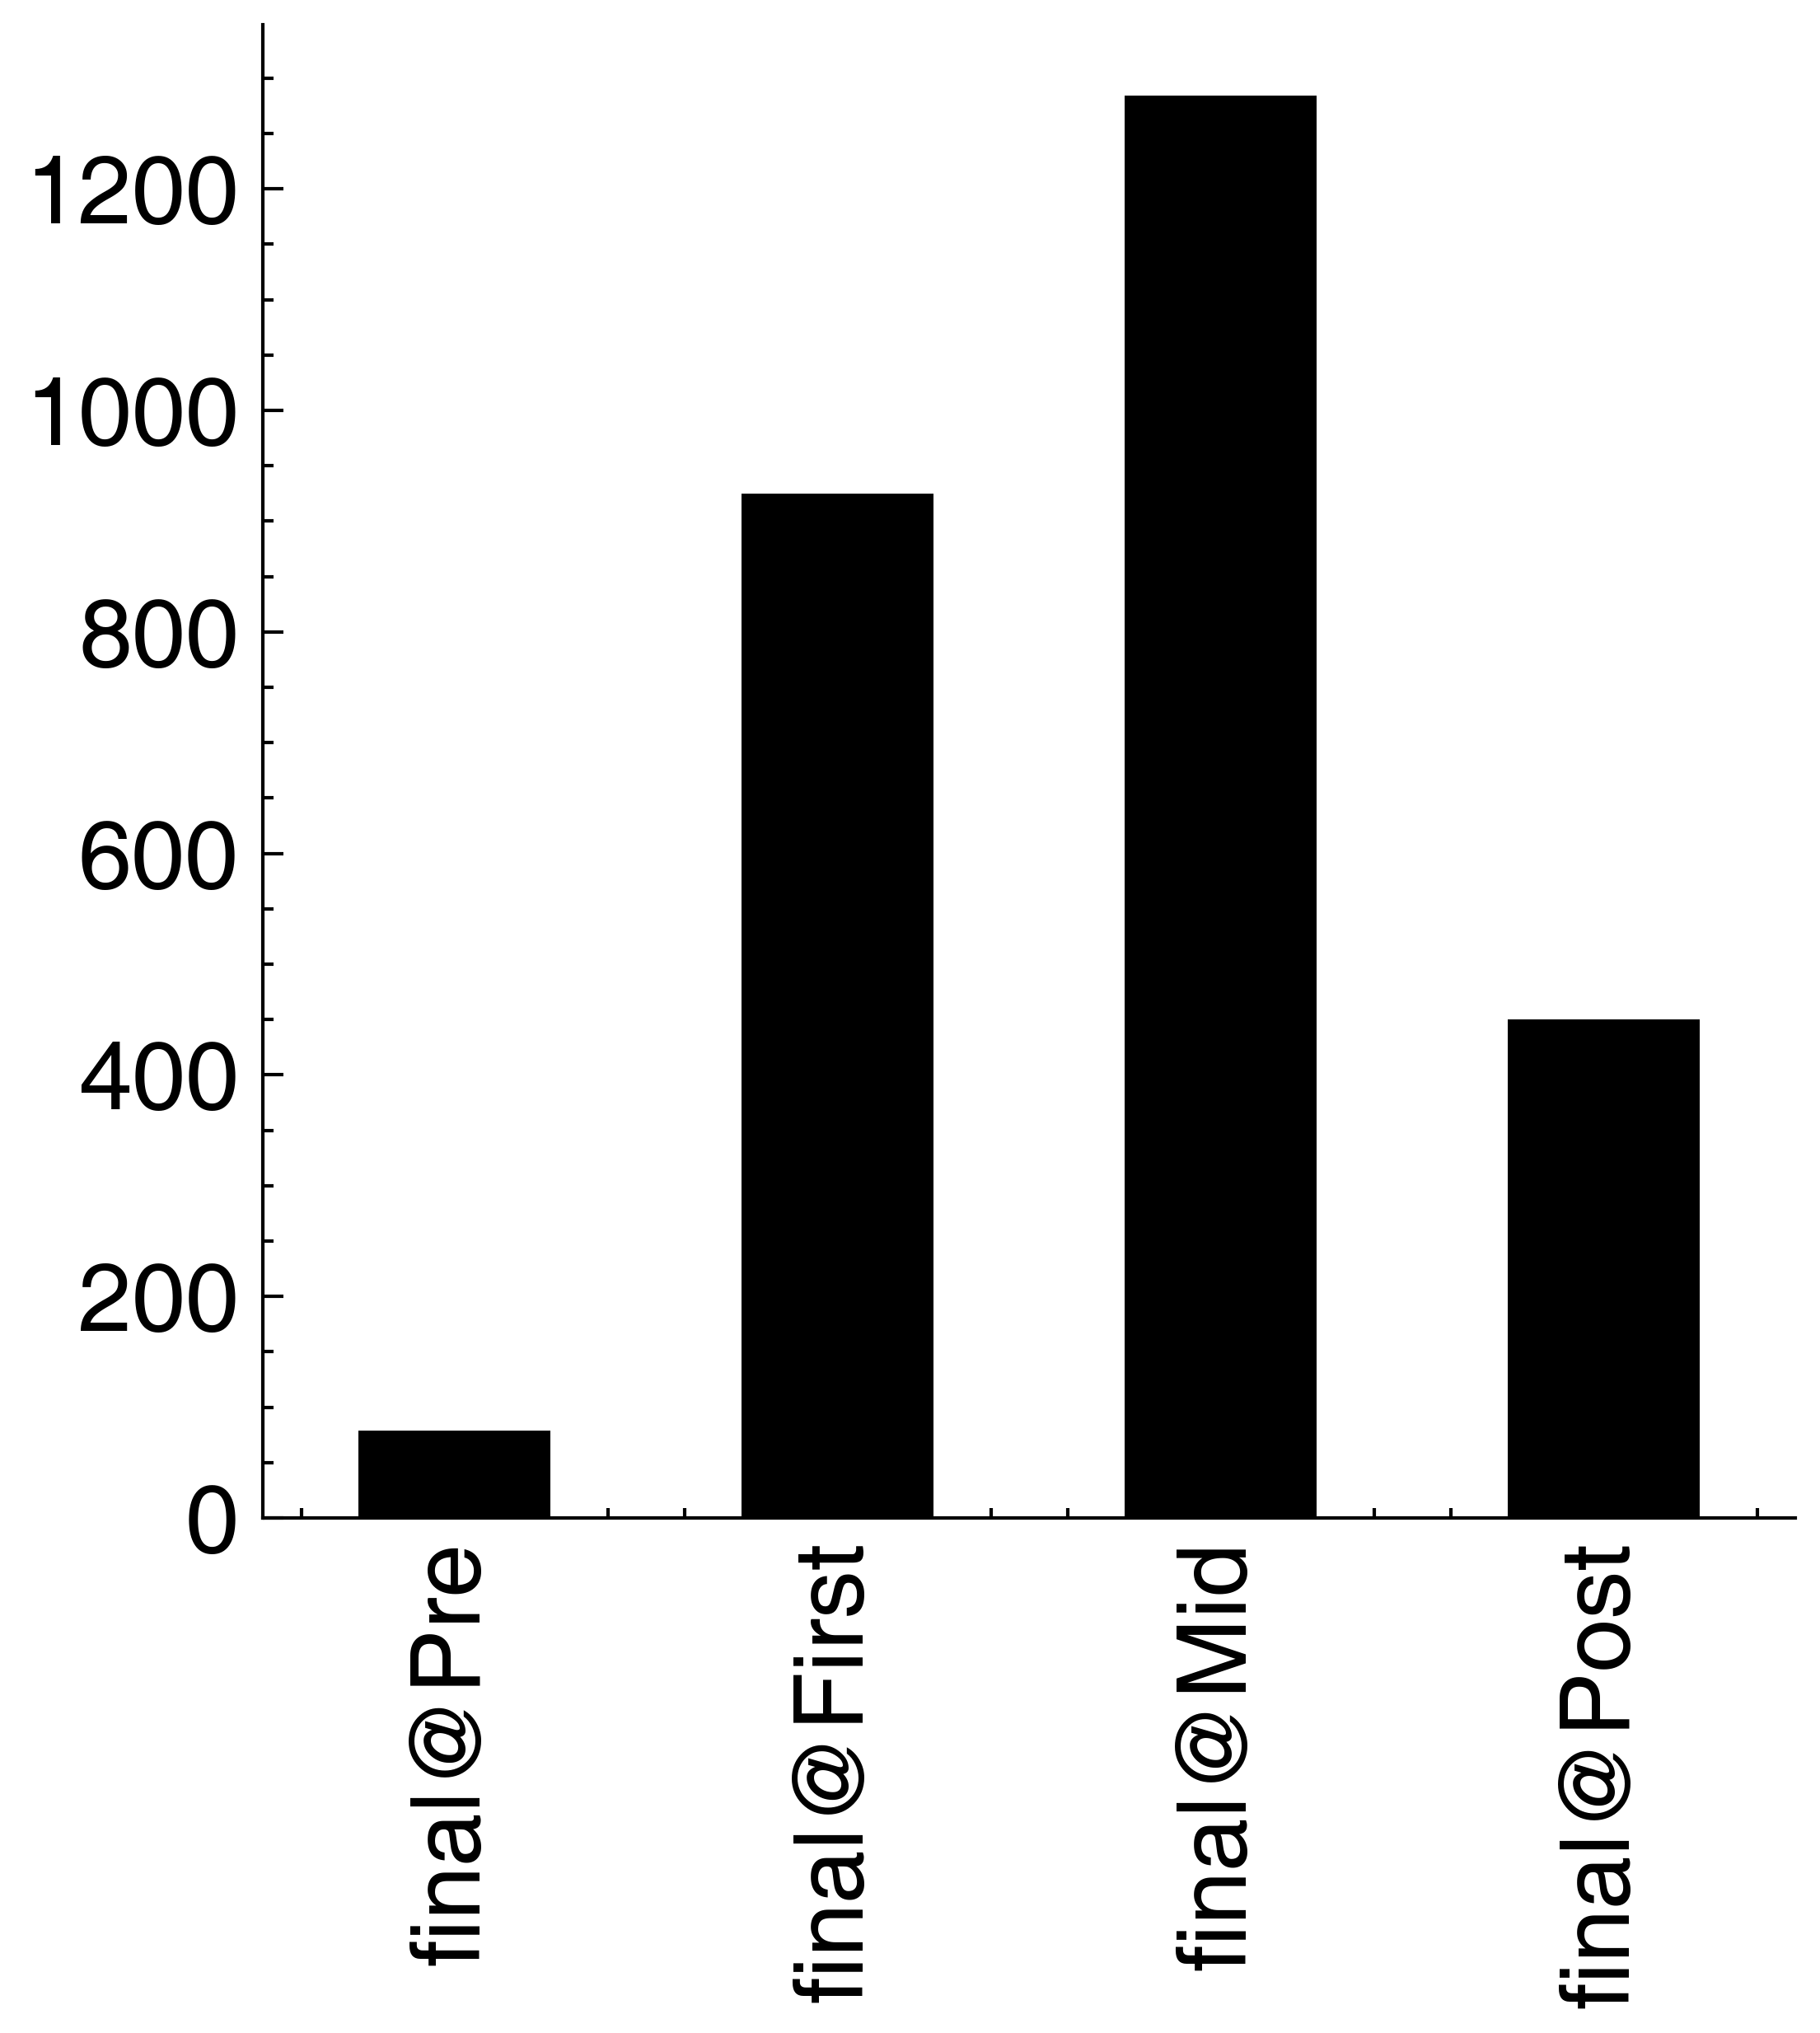

In [9]:
# Plot the number of genes with *any* DAS along the disease progression
cond_to_das_genes = {}
for cond in contrast_cols:
    genes = [g for g in gene_centric_dict if cond in gene_centric_dict[g]]
    cond_to_das_genes[cond] = len(genes)

cond_to_das_genes = pd.Series(cond_to_das_genes, index=contrast_cols)
cond_to_das_genes.loc[
    ['final@Pre',
     'final@First',
     'final@Mid',
     'final@Post'
    ]
].plot(kind='bar')
plt.savefig('%s/01-num_das_genes.pdf' % FIGDIR)

In [10]:
# write GO for ReviGO server
import re
def write_revigo(df, fp, fdr_cutoff=0.01):
    subdf = df.loc[df["Adjusted P-value"] < fdr_cutoff, ['Term', 'Adjusted P-value']].copy()
    subdf['Term'] = [x.split()[-1].strip('()') for x in subdf['Term']]
    subdf = subdf.sort_values('Adjusted P-value', ascending=True)
    subdf.to_csv(fp, sep="\t", index=False)
    return subdf
    
k = 'final@First'
df = gobp_dfs[k]
df = write_revigo(df, fp='./%s/all_genes_splicing/final@First/for_revigo.fdr0.05.txt' % DATA_VER, fdr_cutoff=0.05)
df = write_revigo(df, fp='./%s/all_genes_splicing/final@First/for_revigo.fdr0.01.txt' % DATA_VER, fdr_cutoff=0.01)

In [11]:
k = 'final@Mid'
df = gobp_dfs[k]
df = write_revigo(df, fp='./%s/all_genes_splicing/final@Mid/for_revigo.fdr0.05.txt' % DATA_VER, fdr_cutoff=0.05)
df = write_revigo(df, fp='./%s/all_genes_splicing/final@Mid/for_revigo.fdr0.01.txt' % DATA_VER, fdr_cutoff=0.01)

In [12]:
k = 'UNION'
df = gobp_dfs[k]
df = write_revigo(df, fp='./%s/all_genes_splicing/UNION/for_revigo.fdr0.05.txt' % DATA_VER, fdr_cutoff=0.05)
df = write_revigo(df, fp='./%s/all_genes_splicing/UNION/for_revigo.fdr0.01.txt' % DATA_VER, fdr_cutoff=0.01)

## 3. Temporary change of GO terms 

In [13]:
union_df = gobp_dfs['UNION']
union_df = union_df.loc[union_df['Adjusted P-value']<0.9]
total_union_go_terms = [x for x in union_df['Term']]

In [14]:
gobp_dfs.keys()

dict_keys(['final@Pre', 'final@First', 'final@Mid', 'final@Post', 'final@False Negative', 'final@Immune', 'UNION'])

In [15]:
temporal_conds = ['final@Pre', 'final@First', 'final@Mid', 'final@Post']
union_go = np.zeros((len(total_union_go_terms), len(temporal_conds)))

def compute_overlap(s):
    ol, tot = s.split('/')
    ol = float(ol)
    tot = float(tot)
    p = ol / tot * 100
    std = np.sqrt(p * (1-p) / tot)
    return p, std

for i, cond in enumerate(temporal_conds):
    foo = gobp_dfs[cond].copy()
    foo.index = foo['Term']
    union_go[:, i] = [compute_overlap(foo.loc[k, 'Overlap'])[0] if k in foo.index else 0 for k in total_union_go_terms]

union_go_df = pd.DataFrame(union_go, index=total_union_go_terms, columns=[x.split('@')[1] for x in temporal_conds])

/mnt/home/zzhang/anaconda3/envs/rna-seq/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


In [16]:
union_go_df = union_go_df.replace(0, np.nan)

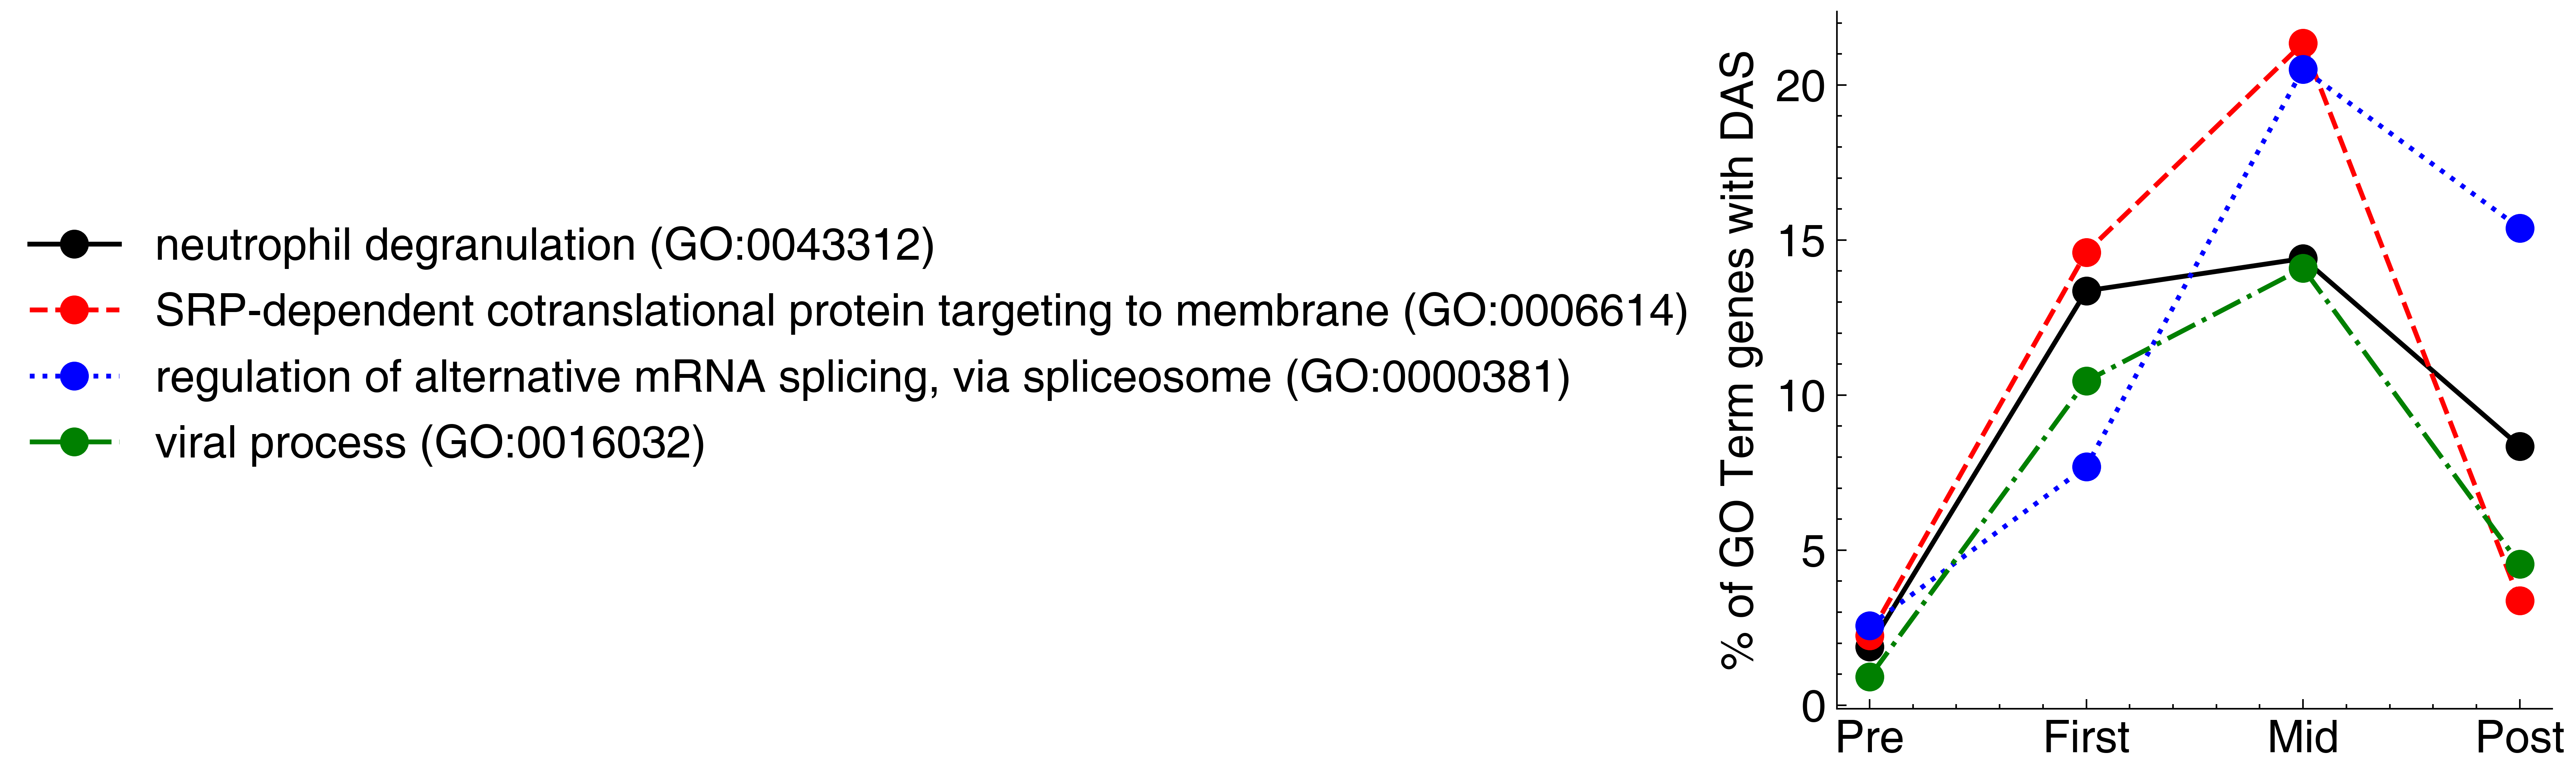

In [17]:
target_go = [
    'neutrophil degranulation (GO:0043312)',
    'SRP-dependent cotranslational protein targeting to membrane (GO:0006614)',
    'regulation of alternative mRNA splicing, via spliceosome (GO:0000381)',
    'viral process (GO:0016032)',
    #'intracellular protein transport (GO:0006886)',
    #'mRNA processing (GO:0006397)',
    #'ribonucleoprotein complex assembly (GO:0022618)',
    #'androgen receptor signaling pathway (GO:0030521)',
    #'intracellular estrogen receptor signaling pathway (GO:0030520)',
    #'positive regulation of type I interferon production (GO:0032481)',
    #'RNA secondary structure unwinding (GO:0010501)',
    #'glycolipid biosynthetic process (GO:0009247)'
    #'protein targeting to vacuole (GO:0006623)'
    #'antigen processing and presentation of exogenous peptide antigen (GO:0002478)',
]

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
union_go_df.loc[target_go].transpose().plot(ax=ax, marker='o')
ax.legend(bbox_to_anchor=(-0.15, 0.75), loc='upper right')
ax.set_ylabel('% of GO Term genes with DAS')
fig.savefig('%s/02-GO_temp_changes.pdf' % FIGDIR)

In [18]:
# export genes with DAS on AS regulation
first_sf_gen = gobp_dfs['final@First'].query('Term=="regulation of alternative mRNA splicing, via spliceosome (GO:0000381)"').Genes.to_list()[0].split(';')
mid_sf_gen = gobp_dfs['final@Mid'].query('Term=="regulation of alternative mRNA splicing, via spliceosome (GO:0000381)"').Genes.to_list()[0].split(';')
sf_gen = list(set(first_sf_gen + mid_sf_gen))

In [19]:
sf_gen_df = pd.DataFrame(columns=['event_id', 'event_type', 'gene', 'condition', 'base_psi', 'delta_psi'])
for gen in sf_gen:
    for cond in gene_centric_dict[gen]:
        for evt in gene_centric_dict[gen][cond]:
            this = {'event_id': evt.event_id, 
                    'event_type': evt.event_type,
                    'gene': gen,
                    'condition': cond,
                    'base_psi': evt._base_psi,
                    'delta_psi': evt._delta_psi
                   }
            sf_gen_df = sf_gen_df.append(this, ignore_index=True)

In [20]:
sf_gen_df.sort_values('condition').to_csv('%s/all_genes_splicing/SplicingFactor_DAS.tsv' % DATA_VER, index=False, sep="\t")
sf_gen_df.sort_values('condition')

,event_id,event_type,gene,condition,base_psi,delta_psi
0,chr19:-:38840559:38841612:38841682:38843841,SE,HNRNPL,final@First,0.102503,-0.013312
2,chr14:+:73111155:73111308:73111382:73111527,SE,RBM25,final@First,0.088485,-0.012007
3,chr14:+:73099666:73099750:73103191:73103478,RI,RBM25,final@First,0.209794,-0.019345
8,chr3:+:152445539:152446703:152446757:152447619,SE,MBNL1,final@First,0.211558,0.025816
17,chr12:+:54282874:54283078:54283234:54283811,SE,HNRNPA1,final@Mid,0.062989,0.004197
16,chrX:-:132406392:132439434:132439572:132489813,SE,MBNL3,final@Mid,0.934209,-0.020493
12,chr1:-:244846706:244847001:244847053:244848787,SE,HNRNPU,final@Mid,0.503955,-0.068719
11,chrX:+:147937600:147938098:147938161:147940575,SE,FMR1,final@Mid,0.196034,-0.029719
9,chr3:+:152445539:152446703:152446757:152447619,SE,MBNL1,final@Mid,0.211558,0.021224
20,chr22:-:38487878:38488115:38492055:38492115,RI,DDX17,final@Mid,0.180957,-0.010177


## 4. Enrichment of CLIP and Pfam annotations

## 4.1 CLIP

In [21]:
das_eids = {
    as_type: [eid for eid in metaloader.data[as_type].stats_tests if \
              (metaloader.data[as_type].stats_tests[eid].loc[contrast_cols, 'qvals']<0.05).sum() > 0]
    for as_type in ('A5SS', 'A3SS', 'RI', 'SE')
}

In [22]:
def plot_volcano(das_eids, ax=None):
    clip_test = ExonSet.enrichment_test(das_eids, metaloader, 'rbp_clip')
    # only look at ENCODE IDR peaks (?)
    clip_test = clip_test.loc[[i for i in clip_test.index if clip_test.loc[i, 'items'].endswith('IDR')]]
    # vocalno plot
    clip_test['log2_ratios'] = np.log2(clip_test['ratios'])
    clip_test['neglog10_pvals'] = -np.log10(clip_test['pvals'])
    clip_test = clip_test.replace([-np.inf, np.inf], np.nan).dropna(axis=0)
    tot_fg = sum([len(das_eids[x]) for x in das_eids])
    #print('total foreground = %i' % tot_fg)
    #clip_test = clip_test.query('observed > %f' % (tot_fg*0.01))
    clip_test = clip_test.query('observed > 50')
    clip_test['fdr'] = fdr_bh(clip_test['pvals'])
    clip_test['labels'] = ''
    clip_test.at[clip_test.query('fdr<0.05').sort_values('fdr', ascending=True).head(3).index, 'labels'] = \
        clip_test['items'].apply(lambda x: x.split('_')[0])
    clip_test.at[clip_test.query('fdr<0.05 and ratios>2').sort_values('fdr', ascending=True).head(3).index, 'labels'] = \
        clip_test['items'].apply(lambda x: x.split('_')[0])
    ax = volcano_plot(
        x='log2_ratios', 
        y='neglog10_pvals', 
        xcut=1,
        ycut=clip_test.query('fdr<0.05').sort_values('neglog10_pvals', ascending=True)['neglog10_pvals'].iloc[0],
        labels='labels', 
        data=clip_test,
        ax=ax
    )
    ax.set_xlabel('log2(Ratio)')
    ax.set_ylabel('log10(Pvalue)')
    return clip_test, ax

/mnt/home/zzhang/anaconda3/envs/rna-seq/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/mnt/home/zzhang/anaconda3/envs/rna-seq/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/mnt/home/zzhang/anaconda3/envs/rna-seq/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


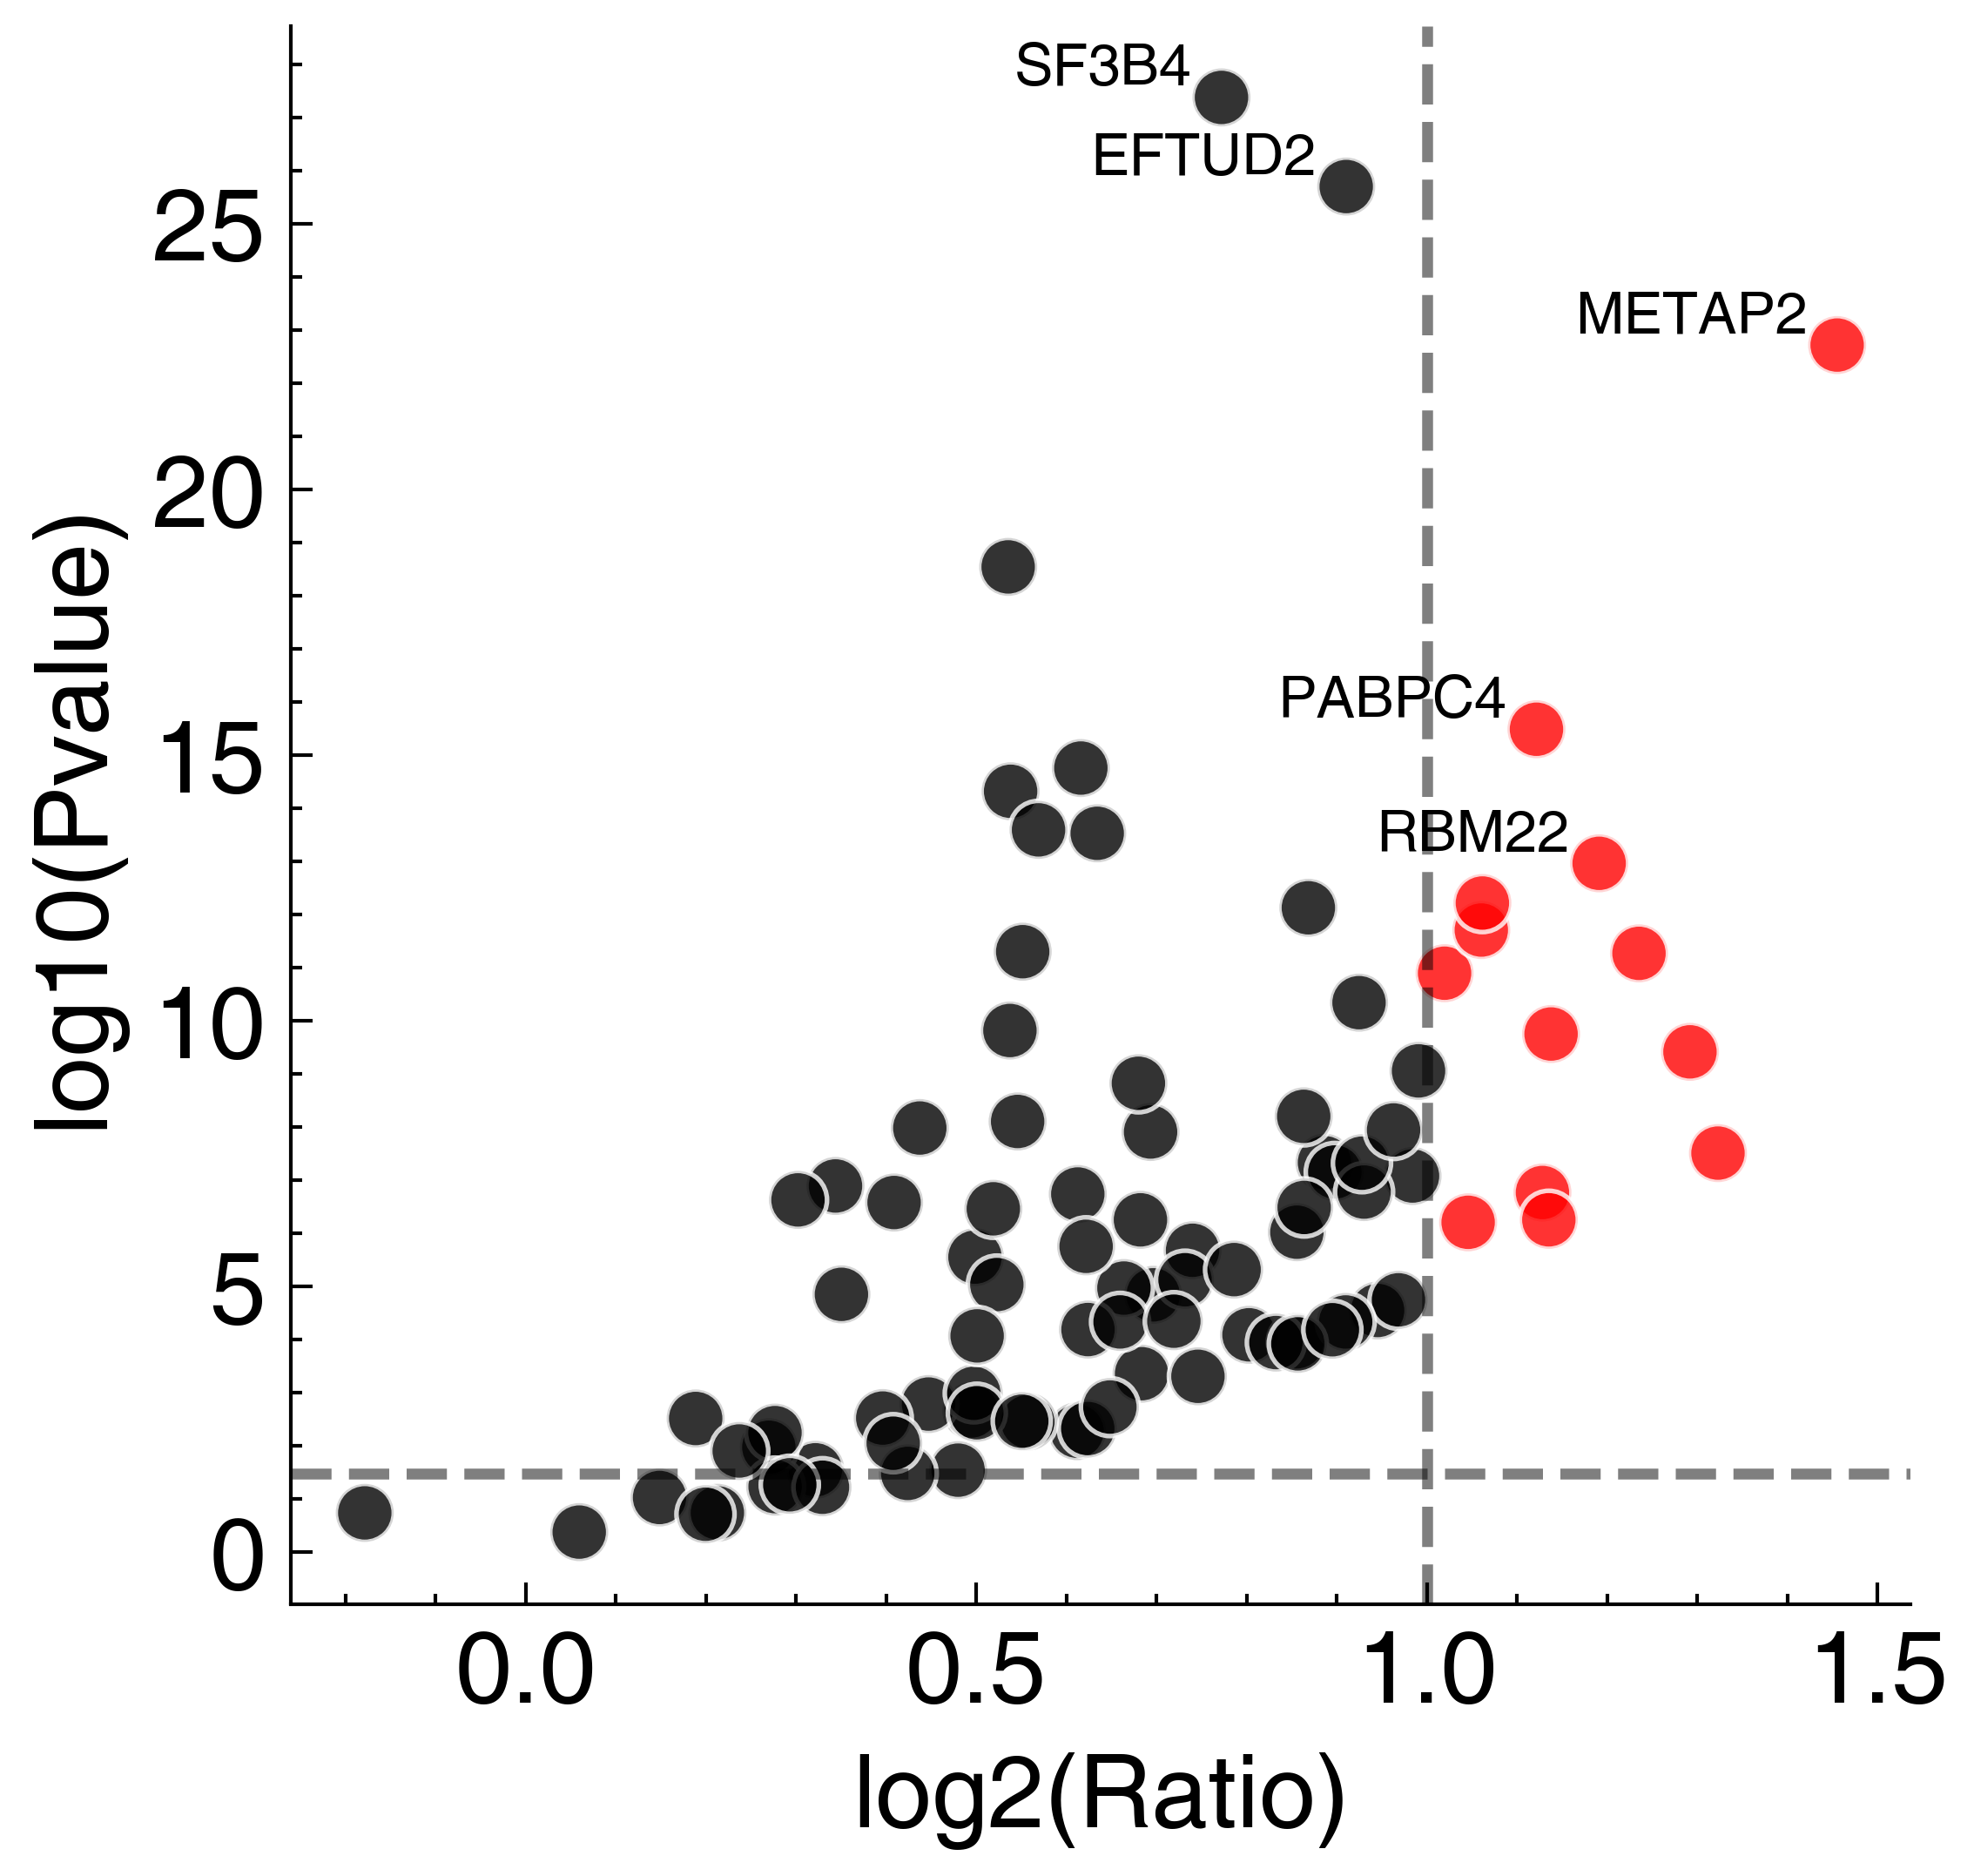

In [23]:
clip_test, ax = plot_volcano(das_eids)
plt.savefig('%s/03-clip_test.pdf'% FIGDIR)
plt.show()

In [24]:
clip_test.query('fdr < 0.05 and ratios>=2').sort_values('fdr', ascending=True)

,items,observed,expected,ratios,pvals,log2_ratios,neglog10_pvals,fdr,labels
298,METAP2_K562_IDR,144,52.512288,2.742215,1.915073e-23,1.455342,22.717815,5.936726e-22,METAP2
136,PABPC4_K562_IDR,153,70.312379,2.176004,3.243468e-16,1.121681,15.488990,6.032851e-15,PABPC4
495,RBM22_K562_IDR,113,49.485061,2.283517,1.080867e-13,1.191258,12.966228,1.005206e-12,RBM22
613,TIAL1_HepG2_IDR,130,62.280138,2.087343,6.038329e-13,1.061668,12.219083,5.105133e-12,
424,ZNF800_K562_IDR,124,59.454727,2.085621,1.947027e-12,1.060477,11.710628,1.392873e-11,
393,PCBP1_K562_IDR,90,38.223779,2.354555,5.345407e-12,1.235455,11.272019,3.314152e-11,
219,SMNDC1_K562_IDR,123,60.665618,2.027508,1.262401e-11,1.019707,10.898803,7.337706e-11,
571,HNRNPK_K562_IDR,89,40.443745,2.200588,1.759647e-10,1.137889,9.754575,8.613008e-10,
579,TIA1_HepG2_IDR,68,27.769757,2.448707,3.810640e-10,1.292020,9.419002,1.771948e-09,
585,APOBEC3C_K562_IDR,51,20.383325,2.502045,3.064916e-08,1.323108,7.513581,1.017990e-07,


## 4.2 Pfam

In [25]:
pfam_test = ExonSet.enrichment_test(das_eids, metaloader, 'pfam_domain')
pfam_test = pfam_test.query('observed > 5')

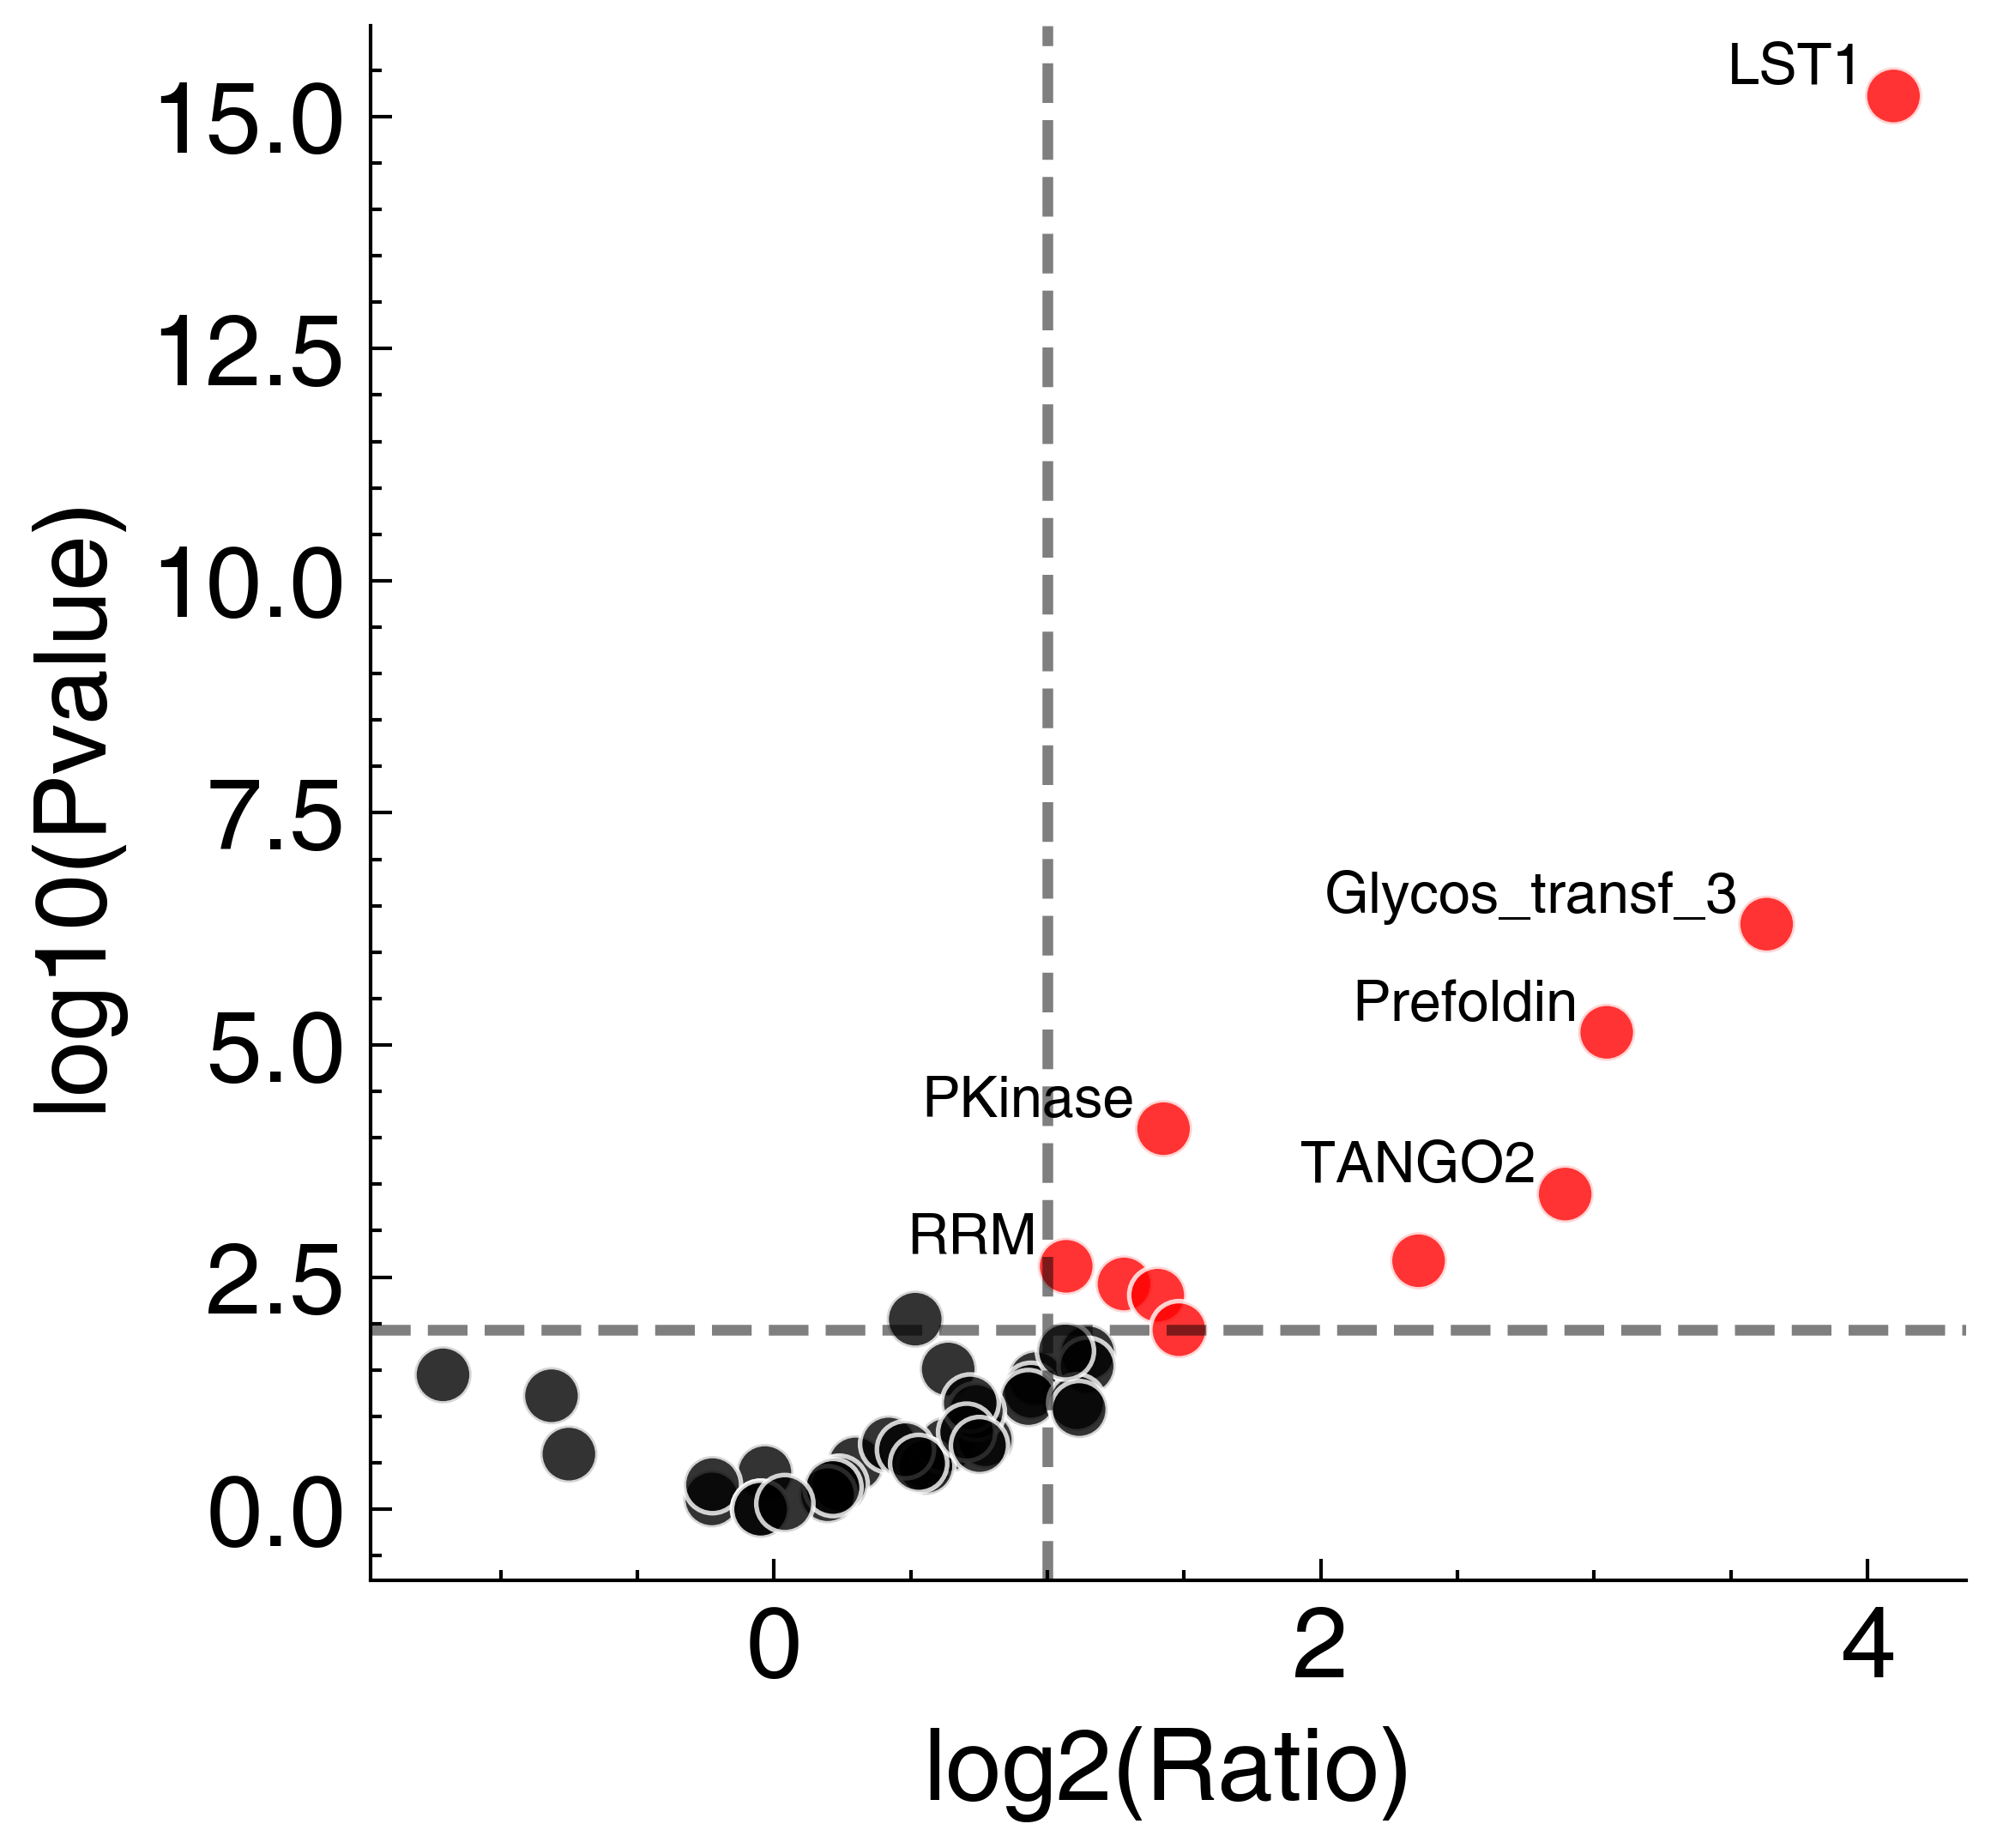

In [26]:
# vocalno plot
pfam_test['log2_ratios'] = np.log2(pfam_test['ratios'])
pfam_test['neglog10_pvals'] = -np.log10(pfam_test['pvals'])
pfam_test['fdr'] = fdr_bh(pfam_test['pvals'])
pfam_test['labels'] = ''
pfam_test.at[pfam_test.query('fdr<0.05').sort_values('fdr', ascending=True).head(6).index, 'labels'] = \
    pfam_test['items']
ax = volcano_plot(
    x='log2_ratios', 
    y='neglog10_pvals', 
    xcut=1,
    ycut=pfam_test.query('fdr<0.05').sort_values('neglog10_pvals', ascending=True)['neglog10_pvals'].iloc[0],
    labels='labels', 
    data=pfam_test)
ax.set_xlabel('log2(Ratio)')
ax.set_ylabel('log10(Pvalue)')
plt.savefig('%s/03-pfam_test.pdf'% FIGDIR)

In [27]:
pfam_test.query('fdr<0.05').sort_values('fdr', ascending=True)

,items,observed,expected,ratios,pvals,log2_ratios,neglog10_pvals,fdr,labels
1203,LST1,20,1.170528,17.086313,6.012780e-16,4.094769,15.220925,2.705751e-14,LST1
1212,Glycos_transf_3,9,0.726534,12.387577,4.992948e-07,3.630822,6.301643,1.123413e-05,Glycos_transf_3
504,Prefoldin,9,1.089802,8.258385,7.297185e-06,3.045860,5.136845,1.094578e-04,Prefoldin
28,PKinase,22,8.193693,2.684992,7.971405e-05,1.424918,4.098465,8.967831e-04,PKinase
38,TANGO2,6,0.807260,7.432546,4.032116e-04,2.893857,3.394467,3.628905e-03,TANGO2
54,RRM,21,10.010029,2.097896,2.419560e-03,1.068943,2.616264,1.555431e-02,RRM
507,Arrestin_N-like,6,1.170528,5.125894,2.107577e-03,2.357804,2.676216,1.555431e-02,
36,Ubiquitin,15,6.175542,2.428937,3.746491e-03,1.280325,2.426375,2.107401e-02,
39,Amidohydrolase,11,4.157391,2.645890,4.955493e-03,1.403753,2.304913,2.477746e-02,
6,P-loop_NTPase,63,44.036054,1.430646,8.978078e-03,0.516667,2.046817,4.040135e-02,


In [28]:
print("FINISH:", datetime.now())

FINISH: 2022-03-22 12:32:25.711079
